In [26]:
import lib
lib.load_styles_and_macros()

AttributeError: module 'lib' has no attribute 'load_styles_and_macros'

<div class="header">
    <div class="title">
    <h1>Programming Exercise 1</h1>
    </div>
    <div class="authors">
       Prof. Dr. Manuel Torrilhon<br/>
       Dr. Michael Redle <br/>
       Vladimir Dordic<br/>
    </div>
</div>

# Workflow

The following notebook will guide you through the first programming exercise sheet. The notebook will contain many functions that are used in different places.
The notebook is devided into the sections:
- Imports
- Review: Basis Functions
- Main FEM Functions (grid, assembleMatrix, rhsConstant, rhsDelta)
- Helper Functions (interpolate, solConstant, solDelta)
- Main Routines (FEM1DConstant, FEM1DDelta)
- L2 error computation(L2Error)
- Plotting Functions (plotResult, plotError)
- Test cases

<div class="alert alert-danger alert-block">
        The main structure of the code is already set up. You only need to add code at places with a '#TODO'comment. Of course, the given structure is only a suggestion.
</div>
The main structure of the code is already set up. You only need to add code at places with a '#TODO'comment. Of course, the given structure is only a suggestion.

The following order of completion is suggested:
1. code the functions 'grid', 'assembleMatrix'(linear case), 'rhsConstant'(linear case), 'FEM1DConstant'(linear case) -> complete Test case 0
2. code the functions 'solConstant', 'interpolate'(linear case), 'L2Error'(linear case) -> complete Test case 1
3. code the functions 'rhsDelta'(linear case), 'FEM1DDelta'(linear case), 'solDelta' -> complete Test case 2
4. complete the functions 'assembleMatrix'(quadratic case), 'rhsConstant'(quadratic case), 'interpolate'(quadratic case), 'L2Error'(quadratic case) -> complete Test case 3
5. complete the functions 'rhsDelta'(quadratic case) -> complete Test case 4 and Error Comparison

# Imports

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, csc_matrix
from scipy.sparse.linalg import spsolve

# Basis Functions

## Linear Basis Function

Linear basis functions are defined using two nodes per element.
$$
\phi_i(x) = 
\begin{cases}
 \frac{x}{x_{i}-x_{i-1}} & \text{for } x \in (x_{i-1}, x_{i}] \\
 \frac{x_{i+1}-x}{x_{i+1}-x_{i}} & \text{for } x \in (x_{i}, x_{i+1}] \\
 0 & \text{elsewhere}
\end{cases}
$$ 
In the following example, the green basis function correpsonds to $\phi_i(x)$ with $x_{i-1} = 0,\, x_i = 1,\, x_{i+1} = 2$. Notice that $\phi_i(x)$ 'overlaps' with $\phi_{i-1}(x)$ and $\phi_{i+1}(x)$.
The illustration shows two elements of the domain, the first element is defined for $ x \in (0, 1]$, the second element is defined for $ x \in (1, 2]$.

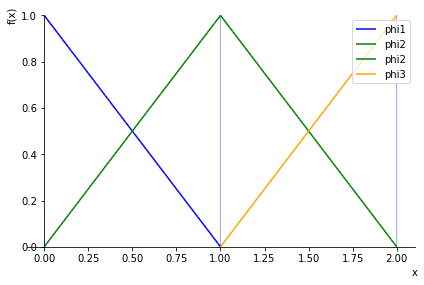

In [ ]:
from sympy.plotting import plot
from sympy import Eq, plot_implicit
from sympy import Symbol
x = Symbol('x') 
p1 = plot(1-x, (x, 0, 1), line_color='blue',   show=False, label='phi1')
p2 = plot(x, (x, 0, 1),line_color='green', show=False, label='phi2')
p3 = plot(2-x, (x, 1, 2), line_color='green', show=False, label='phi2')
p4 = plot( (x-1), (x, 1, 2),line_color='orange',   show=False, label='phi3')
p5 = plot_implicit(Eq(x, 1.0), (x, 0, 2),  show=False)
p6 = plot_implicit(Eq(x, 2.0), (x, 0, 2.1),  show=False)
p1.ylim=(0.0, 1.0)
p1.append(p2[0])
p1.append(p3[0])
p1.append(p4[0])
p1.append(p5[0])
p1.append(p6[0])
p1.legend=True
p1.show()

## Quadratic Basis Function

Quadratic basis functions are defined using three nodes per element.
$$
\phi_i^{edge}(x) = 
\begin{cases}
 \frac{(x_{i-2}-x)(x_{i-1}-x)}{(x_{i-2}-x_{i})(x_{i-1}-x_{i})} & \text{for } x \in (x_{i-2}, x_{i-1}] \\
 \frac{(x-x_{i+1})(x-x_{i+1})}{(x_{i}-x_{i+1})(x_{i}-x_{i+2})} & \text{for } x \in (x_{i}, x_{i+2}] \\
 0 & \text{elsewhere}
\end{cases}
$$ 

$$
\phi_j^{inner}(x) = 
\begin{cases}
 \frac{(x-x_{j-1})(x_{j+1}-x)}{(x_{j}-x_{j-1})(x_{j+1}-x_{j})} & \text{for } x \in (x_{j-1}, x_{j+1}] \\
 0 & \text{elsewhere}
\end{cases}
$$

In the following example, the green basis function correpsonds to $\phi_i^{edge}(x)$ for $x_{i-2} = 0,\, x_{i-1} = 0.5,\, x_{i} = 1,\, x_{i+1} = 1.5,\, x_i{i+2} = 2$. The yellow basis function corresponds to $\phi_j^{inner}(x)$ for $x_{j-1} = 1,\, x_{j} = 1.5,\, x_{j+1} = 2$.
Notice that $\phi_3(x)$ 'overlaps' with four other basis functions, while $\phi_2(x)$ and $\phi_4(x)$ only 'overlap' with two other basis functions.


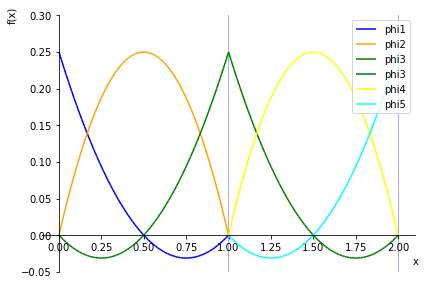

In [ ]:
from sympy.plotting import plot
from sympy import Eq, plot_implicit
from sympy import Symbol
x = Symbol('x') 
p1 = plot( (1/2-x)*(1-x)/2, (x, 0, 1), line_color='blue',   show=False, label='phi1')
p2 = plot((1-x)*(x), (x, 0, 1),line_color='orange', show=False, label='phi2')
p3 = plot((x)*(x-0.5)/2, (x, 0, 1), line_color='green', show=False, label='phi3')
p4 = plot( (3/2-x)*(2-x)/2, (x, 1, 2),line_color='green',   show=False, label='phi3')
p5 = plot((2-x)*(x-1), (x, 1, 2), line_color='yellow', show=False, label='phi4')
p6 = plot((x-1)*(x-3/2)/2, (x, 1, 2),line_color='cyan',  show=False, label='phi5')
p7 = plot_implicit(Eq(x, 1.0), (x, 0, 2),  show=False)
p8 = plot_implicit(Eq(x, 2.0), (x, 0, 2.1),  show=False)
p1.ylim=(-.05, 0.3)
p1.append(p2[0])
p1.append(p3[0])
p1.append(p4[0])
p1.append(p5[0])
p1.append(p6[0])
p1.append(p7[0])
p1.append(p8[0])
p1.legend = True
p1.show()

# FEM Framework

## Main FEM Functions

In [67]:
def grid(N, ansatz='linear'):
    # N: the number of elements
    # ansatz: linear(default) will generate 2 nodes per element. quadratic(else case) generates 3 nodes per element
    # return: a vector containing the node coordinates
    if (ansatz=='linear'):
        vec = np.linspace(0, 1, N+1)
    else:
        vec = np.linspace(0, 1, 2*N+1)
    return vec

The stiffness matrix can directly be computed via
$$
A_{ij} = \int_\Omega \phi'_i(x) \, \phi'_j(x) \, dx \quad,
$$
where the basis functions shall be either linear or quadratic ansatz functions. \
Tips: 
- The integrals can be precomputed.
- In regions where the basis functions do not 'overlap', the integral is 0.
- The solution is known on the boundaries. You therefore only need to compute a solution for the unknown inner nodes of the domain. Choose the size of the stiffness matrix correspondingly.

In [ ]:
def assembleMatrix(lattice, ansatz='linear'):
    # lattice: node vector
    # return: stiffness matrix
    N = len(lattice) - 2
    if (ansatz=='linear'):
        A = np.zeros((N, N))
        h = lattice[1]-lattice[0]
        for i in range(N-1):
            A[i,i] = 2
            A[i,i+1] = -1
            A[i+1,i] = -1
        A[N-1,N-1] = 2
    else:
        #TODO
        A = np.zeros((N, N))
        for i in range(N-1):
            A[i,i] = 2
            A[i,i+1] = -1
            A[i+1,i] = -1
        A[N-1,N-1] = 2
    A = A/h
    return A

The right hand side of the equation can be computed via
$$
b_i(x) = \int_\Omega f(x) \, \phi_i(x) dx 
$$

Tips:
- For a more general purpose FEM solver, you can also change the function definition to 'def rhs(function, lattice, ansatz='linear)'.
- Precomputation of the integral of the delta function is much easier (rhsDelta). The integration of the constant function (rhsConstant) can be numerically evaluated or also precomputed.
- Interation can be done via the 'quad(function, x_0, x_1)' function. Note that this function returns multiple values. The first entry contains the integration result (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html).
- The dimension of the stiffness matrix and the right hand side vector need to be the same.

In [42]:
def rhsConstant(lattice, ansatz='linear'):
    # lattice: node values
    # return: vector of right hand side values
    N = len(lattice) - 2 # number of inner points
    h = lattice[1]-lattice[0]
    if (ansatz=='linear'):
        b = np.zeros(N)
        for i in range(N):
            b[i] = h
    else:
        #TODO
        b = np.zeros(N)
        for i in range(N):
            b[i] = 1
    return b

In [62]:
def rhsDelta(lattice, ansatz='linear'):
    # lattice: node values
    # return: vector of right hand side values
    N = len(lattice) - 2 
    if (ansatz=='linear'):
        b = np.zeros(N)
        for i in range(N):
            if (lattice[i] <= 0.5 and lattice[i+1] > 0.5): # find the element that contains 0.5
                b[i-1] = 2 * (lattice[i+1] - 0.5)/(lattice[i+1] - lattice[i])
                b[i] = 2 - b[i-1]
                break
    else:
        #TODO
        b = np.zeros(N)
        for i in range(N):
            if (lattice[i] <= 0.5 and lattice[i+1] > 0.5):
                b[i] = (lattice[i+1] - 0.5)/(lattice[i+1] - lattice[i])
                b[i+1] = (0.5 - lattice[i+2])/(lattice[i+1] - lattice[i])
                break
    return b

## Helper Functions

In [37]:
def interpolate(x, lattice, u, ansatz='linear'):
    # x: a real number on the domain, where the function shall be evaluated
    # lattice: node vector
    # u: solution vector
    # return: the appoximated solution u(x) 
    if (ansatz=='linear'):
        # assert(x<1)
        # assert(x >= 0)
        i = 0
        while x > lattice[i+1]:
            i += 1
        t = (x - lattice[i]) / (lattice[i+1] - lattice[i])
        return (1 - t) * u[i] + t * u[i+1]
    else:
        assert(x<1)
        assert(x >= 0)
        #TODO
    return #TODO

In [28]:
def solConstant(x):
    # x: a real number (or a vector of real numbers), where the analytic solution is computed
    # return: a real number (or a vector of real numbers) of the analytic solution for f=1
    X =  -0.5*(x-0.5)**2+1/8
    return X

In [54]:
def solDelta(x):
    # x: a real number (or a vector of real numbers), where the analytic solution is computed
    # return: a real number (or a vector of real numbers) of the analytic solution for $f=2 \delta(x-1/2)$
    
    #TODO
    X = 0.5 - np.abs(x-0.5)
    return X


## Main Routines

In [ ]:
def FEM1DConstant(N, ansatz='linear'):
    # N: number of elements
    # ansatz: choose between 'linear' or 'quadratic' ansatz functions
    # return: pair (node vector, solution vector)
    
    # Set up the node vector
    G = grid(N, ansatz)
    
    # Assemble stiffness matrix and right hand side
    A = assembleMatrix(G, ansatz)
    
    # solve
    u = np.zeros(N + 1)
    u[1:N] = np.linalg.solve(A, rhsConstant(G, ansatz))
    
    return G, u
    

In [55]:
def FEM1DDelta(N, ansatz='linear'):
    # N: number of elements
    # ansatz: choose between 'linear' or 'quadratic' ansatz functions
    # return: pair (node vector, solution vector)
    
    # Set up the node vector
    G = grid(N, ansatz)
    
    # Assemble stiffness matrix and right hand side
    A = assembleMatrix(G, ansatz)
    
    # solve
    u = np.zeros(N + 1)
    u[1:N] = np.linalg.solve(A, rhsDelta(G, ansatz))
    
    return G, u

## L2-error

Tips:
- use the interpolate function (which you should define below in the section helper functions)
- Interation can be done via the 'quad(function, x_0, x_1)' function. Note that this function returns multiple values. The first entry contains the integration result (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html).

In [46]:
def L2error(sol, lattice, u, ansatz='linear'):
    # sol: function handle for the analytic solution (see helper functions)
    # lattice: node vector
    # u: solution vector 
    # return: pair (maximal distance between two nodes, L2-error)
    
    #TODO
    h = lattice[1]-lattice[0]
    error, _ = quad(lambda xi: (sol(xi) - np.interp(xi, x, u))**2, x[0], x[-1])
    error = np.sqrt(error)
    
    return h, error

## Functions for Plotting

In [30]:
def plotResult(x, u, X, U, title='Title', ansatz='linear'):
    # x: node vector
    # u: solution vector
    # X: positions (vector), where the analytic solution has been evaluated
    # U: function values (vector) of the analytic solution 
    u_int = np.zeros(X.size)
    for idx, val  in enumerate(X[:-1]):
        u_int[idx] = interpolate(val, x, u, ansatz)
    u_nod = np.zeros(x.size)
    for idx, val  in enumerate(x[:-1]):
        u_nod[idx] = interpolate(val, x, u, ansatz)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(X,u_int, '-.r', label = 'interpolated result')
    ax.plot(x,u_nod, 'xr', label = 'node values')
    ax.plot(X, U, ':', label = 'analytic solution')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(title)
    ax.legend()
    plt.show()

In [32]:
def plotError(x, u, title='L2-error ||u-u_h||_{L^2}'):
    # x: node vector
    # u: solution vector
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.loglog(x,u, 'xr--')
    ax.set_xlabel('max gridsize')
    ax.set_ylabel('error')
    ax.set_title(title)
    ax.invert_xaxis()
    plt.show()

# Test Cases

First, the individual cases for both right hand sides and linear and quadratic basis functions will be tested.
Afterwards, the difference between linear and quadratic basis functions and the influence of specific right hand sides will be investigated.

## Case 0: First quick check

(12,) (12,)


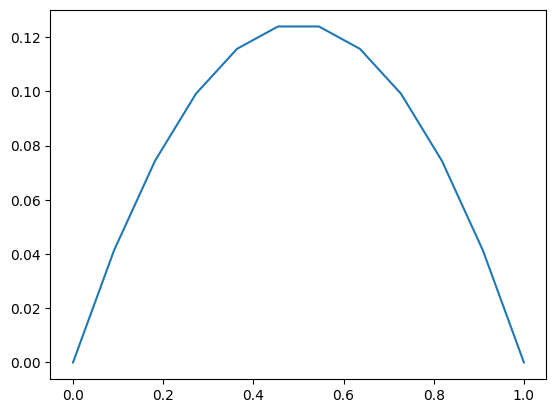

In [43]:
x, u = FEM1DConstant(11)
print(x.shape, u.shape)
plt.plot(x, u)

## Case 1: $f = 1$ (linear)

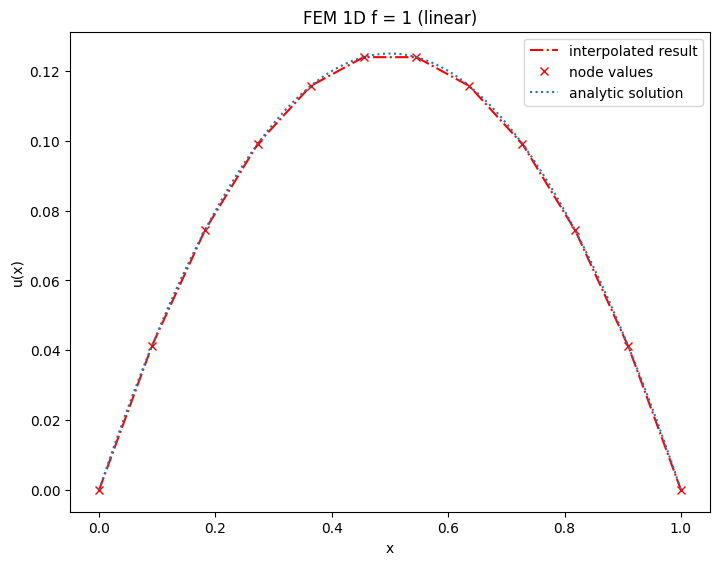

In [44]:
x, u  = FEM1DConstant(11)
X = np.linspace(0, 1, 1000)
U = solConstant(X)
plotResult(x, u, X, U, title='FEM 1D f = 1 (linear)')

In [47]:
N = np.linspace(10, 1000, 50, dtype=int)
N[::2] = N[::2] + 1
errorConstantLinear = np.zeros(N.size)
maxGridsize = np.zeros(N.size)
for i, n in enumerate(N):
    x, u = FEM1DConstant(n)
    maxGridsize[i], errorConstantLinear[i] = L2error(solConstant, x, u)
    

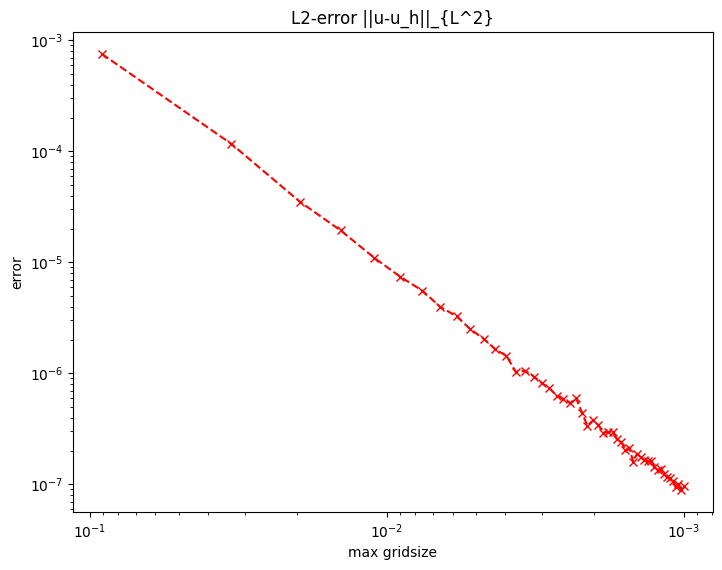

In [48]:
plotError(maxGridsize, errorConstantLinear)

## Case 2: $f(x) = 2\delta(x-1/2)$ (linear)

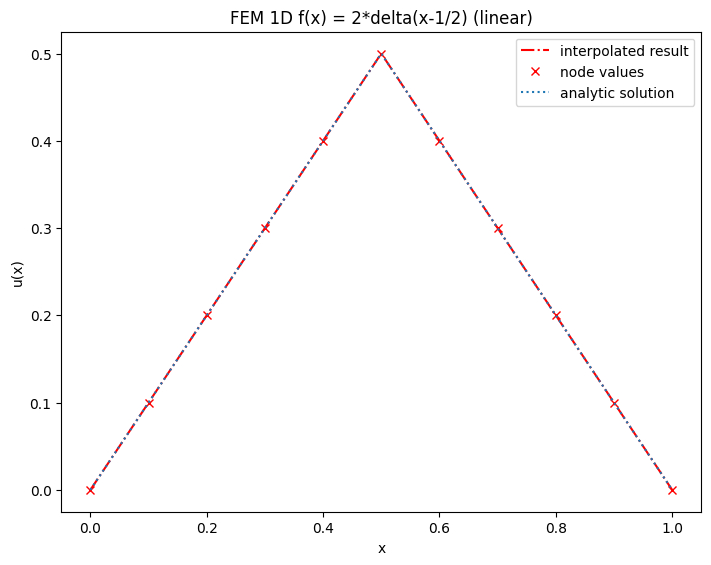

In [63]:
x, u  = FEM1DDelta(10)
X = np.linspace(0, 1, 1000)
U = solDelta(X)
plotResult(x, u, X, U, title='FEM 1D f(x) = 2*delta(x-1/2) (linear)')

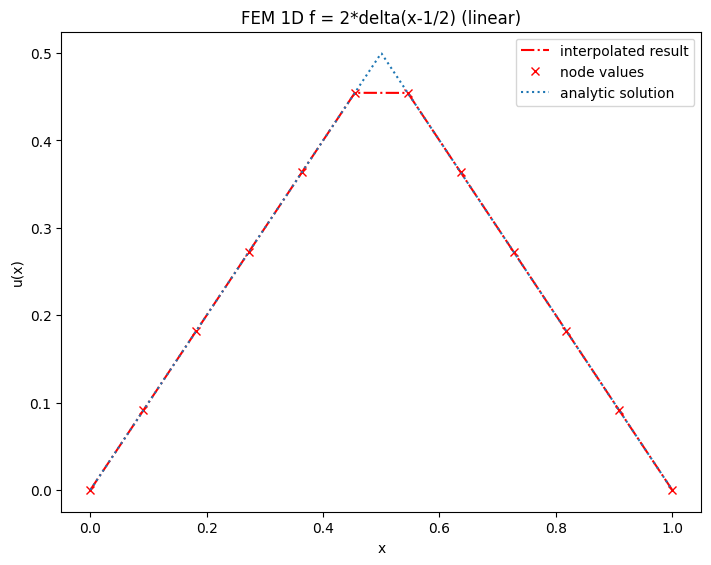

In [64]:
x, u  = FEM1DDelta(11)
X = np.linspace(0, 1, 1000)
U = solDelta(X)
plotResult(x, u, X, U, title='FEM 1D f = 2*delta(x-1/2) (linear)')

In [65]:
N = np.linspace(10, 1000, 50, dtype=int)
N[::2] = N[::2] + 1
errorDeltaLinear = np.zeros(N.size)
maxGridsize = np.zeros(N.size)
for i, n in enumerate(N):
    x, u = FEM1DDelta(n)
    maxGridsize[i], errorDeltaLinear[i] = L2error(solDelta, x, u)
    

C:\Users\Jiayin Hu\AppData\Local\Temp\ipykernel_23484\2731512627.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  error, _ = quad(lambda xi: (sol(xi) - np.interp(xi, x, u))**2, x[0], x[-1])


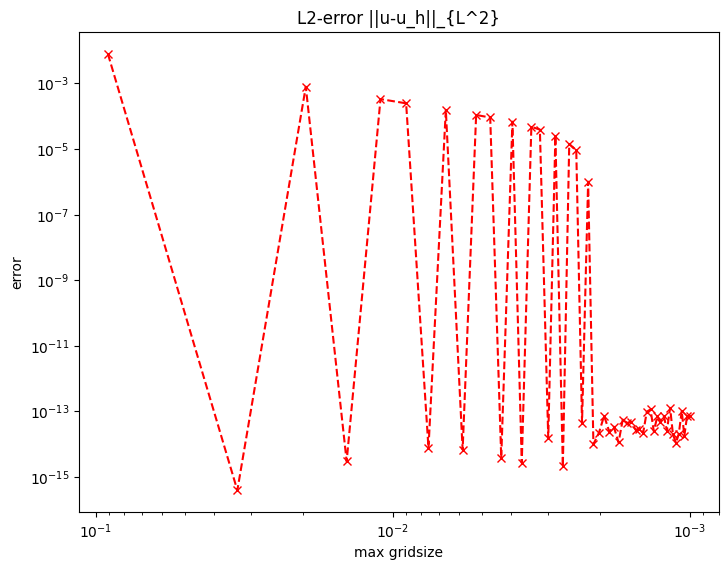

In [66]:
plotError(maxGridsize, errorDeltaLinear)

## Case 3: $f=1$ (quadratic)

In [ ]:
xL, uL = FEM1DConstant(10)
xQ, uQ  = FEM1DConstant(5, 'quadratic')
X = np.linspace(0, 1, 1000)
U = solConstant(X)
plotResult(xQ, uQ, X, U, title='FEM 1D f = 1 (quadratic)', ansatz='quadratic')
plotResult(xL, uL, X, U, title='FEM 1D f = 1 (linear)')
print('L2-error (quadratic)', L2error(solConstant, xQ, uQ, 'quadratic'))
print('L2-error (linear)', L2error(solConstant, xL, uL))

In [ ]:
N = np.linspace(10, 1000, 50, dtype=int)
N[::2] = N[::2] + 1
errorConstantQuadratic = np.zeros(N.size)
maxGridsize = np.zeros(N.size)
for i, n in enumerate(N):
    x, u = FEM1DConstant(n, 'quadratic')
    maxGridsize[i], errorConstantQuadratic[i] = L2error(solConstant, x, u, 'quadratic')

In [ ]:
plotError(maxGridsize, errorConstantQuadratic)

## Case 4: $f(x) = 2\delta(x-1/2)$   (quadratic)

In [ ]:
x, u  = FEM1DDelta(3,  'quatratic')
X = np.linspace(0, 1, 1000)
U = solDelta(X)
plotResult(x, u, X, U, title='FEM 1D f(x) = 2*delta(x-1/2) (quadratic)', ansatz='quadratic')
print(L2error(solDelta, x, u, 'quadratic'))

In [ ]:
x, u  = FEM1DDelta(4, 'quadratic')
X = np.linspace(0, 1, 1000)
U = solDelta(X)
plotResult(x, u, X, U, title='FEM 1D f(x) = 2*delta(x-1/2) (quadratic)', ansatz='quadratic')
print(L2error(solDelta, x, u, 'quadratic'))

In [ ]:
N = np.linspace(10, 1000, 50, dtype=int)
N[::2] = N[::2] + 1
errorDeltaQuadratic = np.zeros(N.size)
maxGridsize = np.zeros(N.size)
for i, n in enumerate(N):
    x, u = FEM1DDelta(n, 'quadratic')
    maxGridsize[i], errorDeltaQuadratic[i] = L2error(solDelta, x, u, 'quadratic')
    

In [ ]:
plotError(maxGridsize, errorDeltaQuadratic)

# Error Comparison

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.loglog(maxGridsize, errorDeltaLinear, 'og', label='delta linear')
ax.loglog(maxGridsize, errorDeltaQuadratic, 'or', label='delta quadratic')
ax.set_xlabel('max gridsize')
ax.set_xlabel('max gridsize')
ax.set_ylabel('error')
ax.set_title('Error comparison')
ax.invert_xaxis()
ax.legend()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.loglog(maxGridsize, errorConstantLinear, '.g--', label='constant linear')
ax.loglog(maxGridsize, errorConstantQuadratic, '.r--', label='constant quadratic')
ax.set_xlabel('max gridsize')
ax.set_ylabel('error')
ax.set_title('Error comparison')
ax.invert_xaxis()
ax.legend()
plt.show()